In [1]:
import sys
sys.path.append("../../")

from scipy.interpolate import CubicSpline
import math
import numpy as np
import matplotlib.pyplot as plt

from didgelab.evo.nuevolution import GeoGenome
from didgelab.calc.geo import Geo, geotools
from didgelab.util.didge_visualizer import vis_didge
from didgelab.calc.sim.sim import compute_impedance_iteratively, get_notes, compute_impedance, create_segments, get_log_simulation_frequencies


(1666.8088018810297, 28.8)


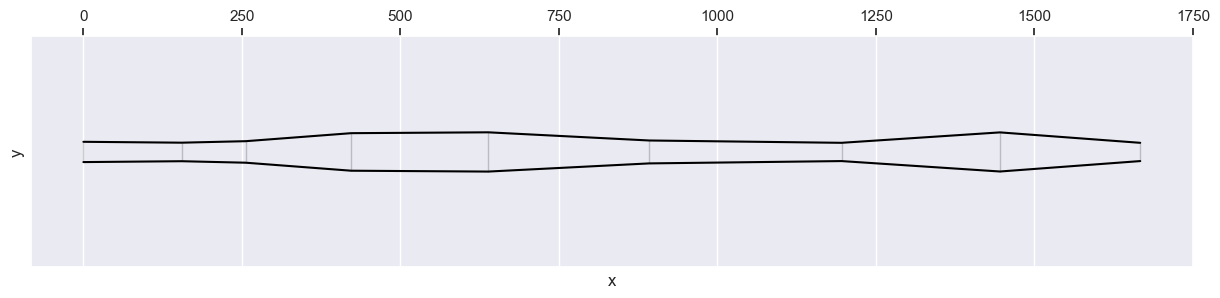

(1666.8088018810297, 28.8)


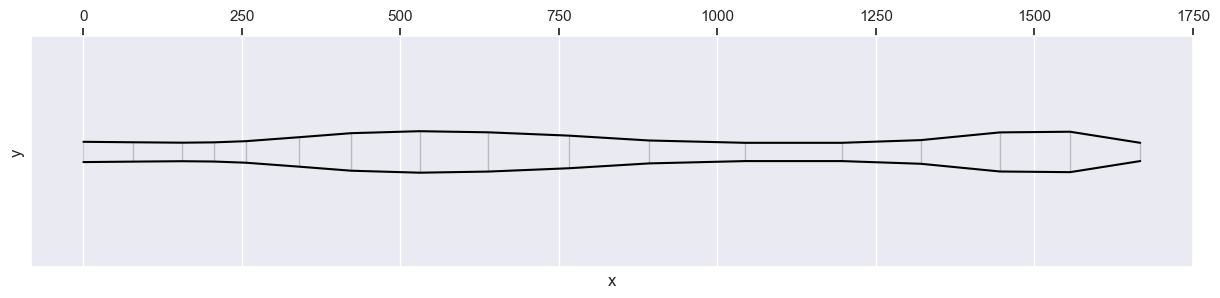

In [3]:
class SplineShape(GeoGenome):

    def __init__(
        self,
        init_resolution = 5, 
        d0=32, 
        d_bell_min=50, 
        d_bell_max=80,
        max_length = 1900, 
        min_length = 1500):

        self.max_length = max_length
        self.min_length = min_length
        self.resolution = init_resolution
        self.init_resolution = init_resolution
        self.d0 = 32
        self.d_bell_min = d_bell_min
        self.d_bell_max = d_bell_max

        self.geo_offset = 3
        GeoGenome.__init__(self, n_genes = 3+2*init_resolution)

    def get_properties(self):
        length = self.genome[0] * (self.max_length-self.min_length) + self.min_length
        bell_size = self.genome[1] * (self.d_bell_max - self.d_bell_min) + self.d_bell_min
        power = self.genome[2]*2

        x_genome = np.array([self.genome[i] for i in range(self.geo_offset, len(self.genome), 2)])
        y_genome = np.array([self.genome[i] for i in range(self.geo_offset+1, len(self.genome), 2)])

        return length, bell_size, power, x_genome, y_genome

    def genome2geo(self):
        length, bell_size, power, x_genome, y_genome = self.get_properties()
        x, y, normalization = self.make_shape(x_genome, y_genome, length, self.d0, bell_size, power)
        x, y = self.fix_didge(x, y, self.d0, bell_size)
        geo = list(zip(x,y))
        return Geo(list(zip(x,y)))
    
    def double_resolution(self):
        length, bell_size, power, x_genome, y_genome = self.get_properties()
        x1, y1, normalization = self.make_shape(x_genome, y_genome, length, self.d0, bell_size, power)
        x2, y2 = self.smooth(x1, y1)
        x3, y3 = self.backward(x2, y2, x_genome, y_genome, normalization, length, self.d0, bell_size, power)

        genome = self.genome[0:self.geo_offset].tolist()
        for i in range(len(x3)):
            genome.append(x3[i])
            genome.append(y3[i])
        self.genome = np.array(genome)

    def smooth(self, x1,y1):
        cs = CubicSpline(x1, y1)

        x2 = [0]
        for i in range(1, len(x1)):
            x2.append(0.5*(x1[i]+x1[i-1]))
            x2.append(x1[i])
        y2 = cs(x2)

        x2 = np.array(x2)
        return x2,y2

    def basic_y_shape(self, n, bellsize, power, d0):
        y= np.arange(n+1)/n
        y = np.power(y, power)
        y = np.power(y, power)
        y = np.power(y, power)
        y = d0 + y*(bellsize - d0)
        return y

    def make_shape(self, x_genome, y_genome, length, d0, bellsize, power):
        x_genome = x_genome.copy()

        x = [0]
        x_genome += 0.3
        for i in range(len(x_genome)):
            x.append(x[-1] + x_genome[i])

        x = np.array(x)    

        normalization = x[-1]
        x /= x[-1]
        x *= length

        y = y_genome.copy()
        y -= 0.5
        y *= 120
        y = np.concatenate(([0], y))
        y_basic = self.basic_y_shape(len(y)-1, bellsize, power, d0)
        y = y_basic + y
        return x,y, normalization

    def fix_didge(self, x,y, d0, bellsize):
        mind = d0*0.9
        x=x.copy()
        y=y.copy()
        y[y<mind] = mind
        maxd = bellsize
        y[y>maxd] = maxd#
        return x,y

    def backward(self, x_smooth, y_smooth, x_genome, y_genome, normalization, length, d0, bellsize, power):
        odd = lambda x: np.array([x[i] for i in range(0, len(x), 2)])
        x_new = x_smooth/length
        x_new *= normalization

        x2 = []
        for i in range(len(x_new)-1):
            x2.append(x_new[i+1]-x_new[i])
        x_new = np.array(x2)
        x_new -= 0.3

        basic_y = self.basic_y_shape(len(y_smooth)-1, bellsize, power, d0)

        y_new = y_smooth - basic_y
        y_new = y_new[1:]
        y_new /= 120
        y_new += 0.5
        return x_new, y_new

def mini_report(geo):
    print(geo.geo[-1])
    vis_didge(geo)
    plt.show()

np.random.seed(1)
didge = SplineShape(init_resolution=8)

length, bell_size, power, x_genome, y_genome = didge.get_properties()
x, y, normalization = didge.make_shape(x_genome, y_genome, length, didge.d0, bell_size, power)
geo1 = didge.genome2geo()
geo = mini_report(geo1)
didge.double_resolution()
geo2 = didge.genome2geo()
mini_report(geo2)

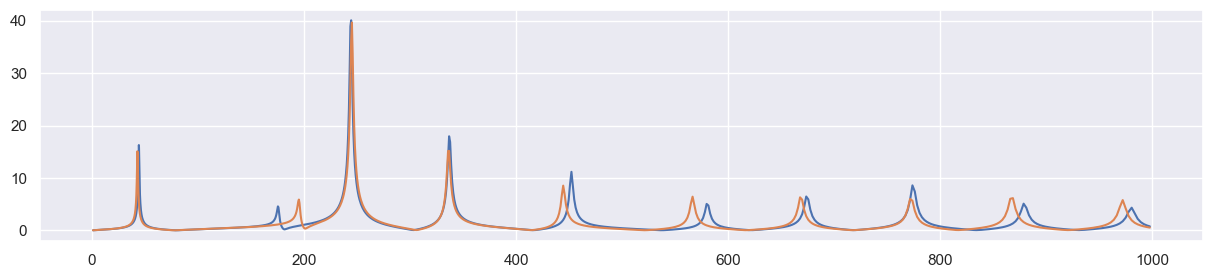

In [5]:
freqs = get_log_simulation_frequencies(1, 1000, 5)
segments = create_segments(geo1)
impedances1 = compute_impedance(segments, freqs)
segments = create_segments(geo2)
impedances2 = compute_impedance(segments, freqs)
#notes = get_notes(freqs, impedances)
plt.plot(freqs, impedances1)
plt.plot(freqs, impedances2)